In [33]:
import pandas as pd
import os
from IPython.display import display

# 1. 회원정보 파일 경로 리스트
member_file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201807_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201808_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201809_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201810_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201811_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201812_train_회원정보.parquet"
]

# 2. 신용정보 파일 경로 리스트
credit_file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201807_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201808_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201809_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201810_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201811_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201812_train_신용정보.parquet"
]

# 3. 기준년월 컬럼 추가 및 병합 함수
def load_and_merge_parquet(file_paths):
    df_list = []
    for path in file_paths:
        df = pd.read_parquet(path)
        기준년월 = os.path.basename(path).split('_')[0]
        df['기준년월'] = 기준년월
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

# 4. 데이터 로딩
member_df = load_and_merge_parquet(member_file_paths)
credit_df = load_and_merge_parquet(credit_file_paths)

# 5. segment 컬럼 자동 탐색 및 숫자형 변환
segment_col_candidates = [col for col in member_df.columns if 'segment' in col.lower()]
print("사용 가능한 segment 컬럼 후보:", segment_col_candidates)

segment_col = segment_col_candidates[-1]  # 예: 'Segment'
if member_df[segment_col].dtype == 'object':
    member_df[segment_col] = member_df[segment_col].astype('category').cat.codes

# 6. 병합 ('ID', '기준년월' 기준)
merged_df = pd.merge(member_df, credit_df, on=['ID', '기준년월'], how='inner')

# 7. 다시 segment 숫자형 확인 (혹시 string으로 남았을 경우)
if merged_df[segment_col].dtype == 'object':
    merged_df[segment_col] = merged_df[segment_col].astype('category').cat.codes

# 8. 숫자형 컬럼 추출
numeric_cols = [col for col in clean_df.columns if col != segment_col]

# 9. 결측치 제거 + std=0 제거
clean_df = merged_df[numeric_cols + [segment_col]].dropna()
clean_df = clean_df.loc[:, clean_df.std() != 0]

# 10. 상관계수 계산
corr_dict = {col: clean_df[segment_col].corr(clean_df[col]) for col in numeric_cols}

# 11. 결과 정리
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['상관계수'])
corr_df = corr_df.sort_values(by='상관계수', key=abs, ascending=False)
corr_df.reset_index(inplace=True)
corr_df.rename(columns={'index': '컬럼명'}, inplace=True)

# 12. 보기 좋게 출력 (스타일링)
styled = corr_df.style.background_gradient(cmap='coolwarm', subset=['상관계수']) \
                    .set_properties(**{'text-align': 'center'}) \
                    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

# 13. 출력
display(styled)

사용 가능한 segment 컬럼 후보: ['Segment']


,컬럼명,상관계수
0,이용금액_R3M_신용체크,-0.594505
1,이용금액_R3M_신용,-0.561759
2,_1순위카드이용금액,-0.559017
3,_2순위카드이용금액,-0.352529
4,이용카드수_신용체크,-0.343764
5,_1순위카드이용건수,-0.334453
6,_2순위카드이용건수,-0.321473
7,이용가능카드수_신용체크,-0.313028
8,이용카드수_신용,-0.312458
9,유효카드수_신용체크,-0.310749


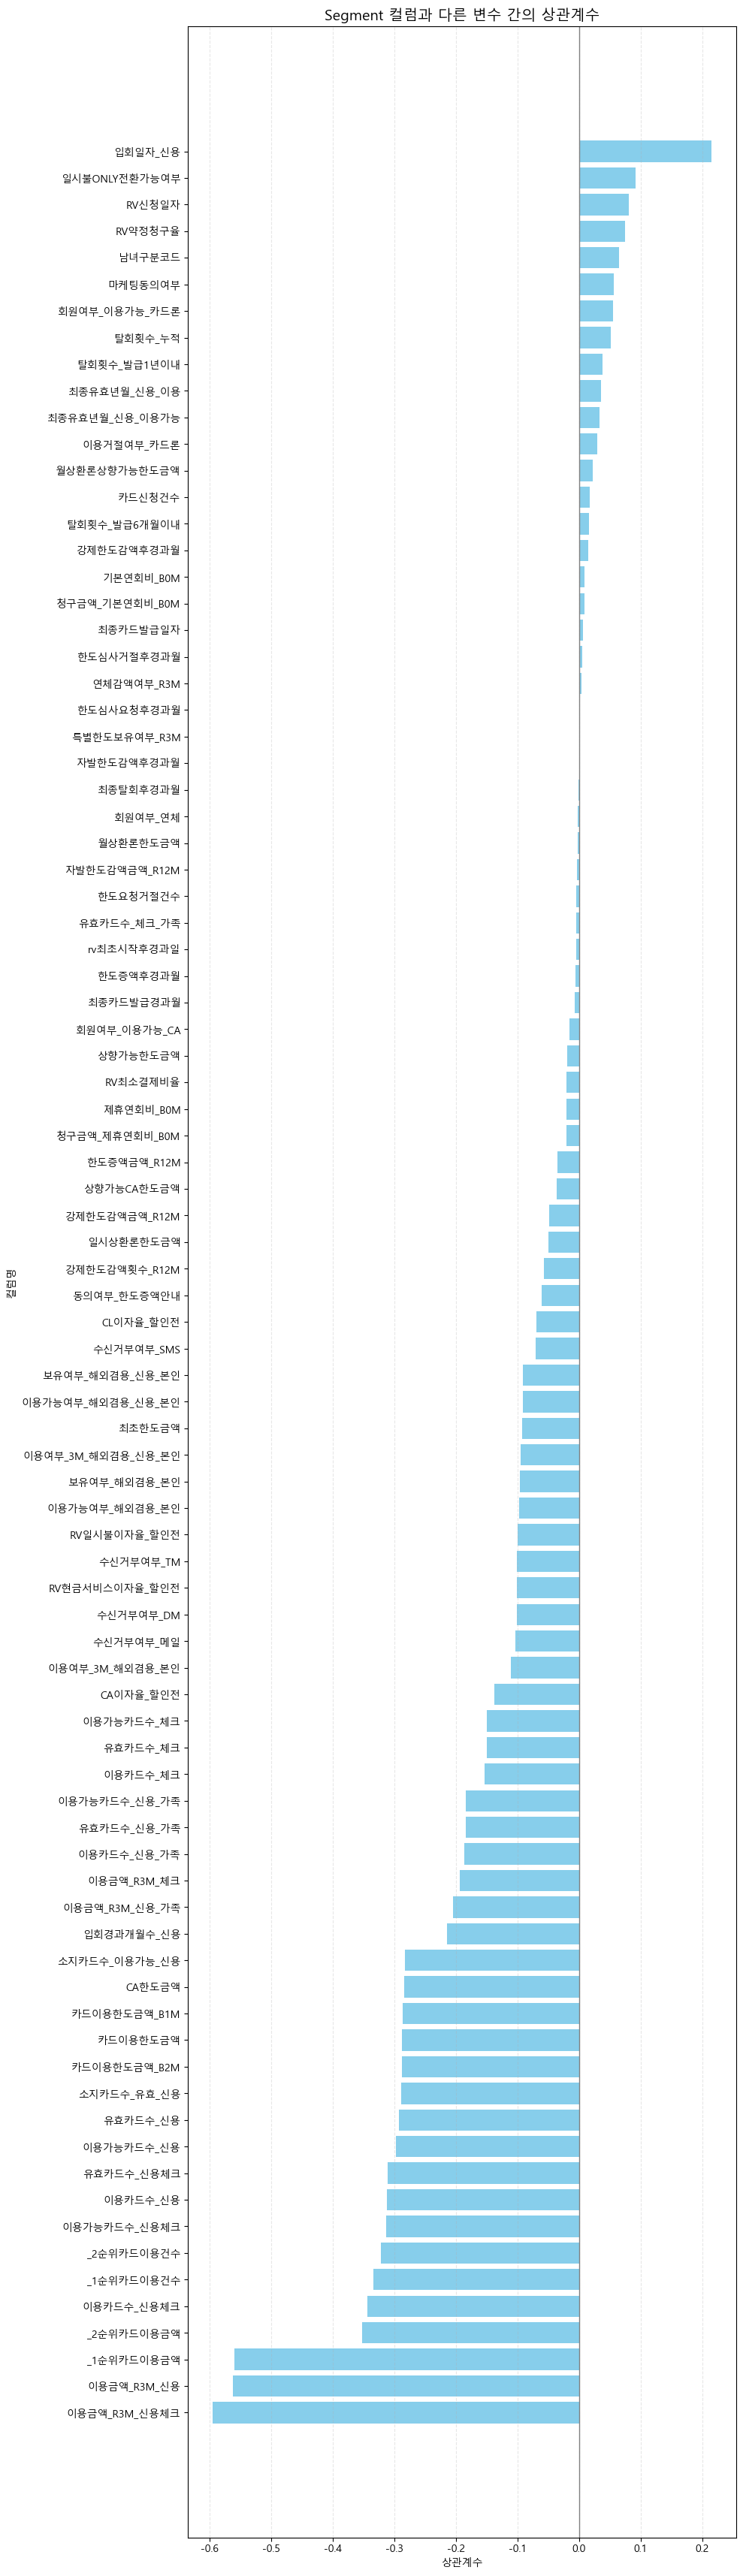

In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 + 음수 기호 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# 상관계수 기준으로 정렬
corr_df_sorted = corr_df.sort_values(by='상관계수')

# 시각화
plt.figure(figsize=(10, len(corr_df_sorted) * 0.4))  # 길이에 따라 크기 자동 조절
plt.barh(corr_df_sorted['컬럼명'], corr_df_sorted['상관계수'], color='skyblue')

plt.title("Segment 컬럼과 다른 변수 간의 상관계수", fontsize=14)
plt.xlabel("상관계수")
plt.ylabel("컬럼명")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.axvline(0, color='gray', linewidth=1)  # 기준선
plt.tight_layout()
plt.show()



In [36]:
corr_filtered = corr_df[abs(corr_df['상관계수']) >= 0.3]
print("선별된 변수 수:", len(corr_filtered))
display(corr_filtered)

선별된 변수 수: 10


,컬럼명,상관계수
0,이용금액_R3M_신용체크,-0.594505
1,이용금액_R3M_신용,-0.561759
2,_1순위카드이용금액,-0.559017
3,_2순위카드이용금액,-0.352529
4,이용카드수_신용체크,-0.343764
5,_1순위카드이용건수,-0.334453
6,_2순위카드이용건수,-0.321473
7,이용가능카드수_신용체크,-0.313028
8,이용카드수_신용,-0.312458
9,유효카드수_신용체크,-0.310749


In [39]:
print(selected_df.columns.tolist())


['이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액', '_2순위카드이용금액', '이용카드수_신용체크', '_1순위카드이용건수', '_2순위카드이용건수', '이용가능카드수_신용체크', '이용카드수_신용', '유효카드수_신용체크', 'Segment']


In [41]:
import os

# 저장할 폴더 경로
output_dir = "C:/Users/HR/Desktop/workspace/파이널프로젝트"
output_path = os.path.join(output_dir, "segment_신용정보_상관계수_0.3이상.csv")


# 저장
selected_df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"저장 완료: {output_path}")


저장 완료: C:/Users/HR/Desktop/workspace/파이널프로젝트\segment_신용정보_상관계수_0.3이상.csv


In [3]:
import pandas as pd
import os

# 1. 회원정보 파일 경로 리스트
member_file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201807_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201808_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201809_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201810_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201811_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201812_train_회원정보.parquet"
]

# 2. 마케팅정보 파일 경로 리스트
marketing_file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201807_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201808_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201809_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201810_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201811_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201812_train_신용정보.parquet"
]

# 3. 기준년월 컬럼 추가 및 병합 함수
def load_and_merge_parquet(file_paths):
    df_list = []
    for path in file_paths:
        df = pd.read_parquet(path)
        기준년월 = os.path.basename(path).split('_')[0]
        df['기준년월'] = 기준년월
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

# 4. 데이터 로딩
member_df = load_and_merge_parquet(member_file_paths)
marketing_df = load_and_merge_parquet(marketing_file_paths)

# 5. Segment 컬럼 자동 탐색 및 숫자형 변환
segment_col_candidates = [col for col in member_df.columns if 'segment' in col.lower()]
print("사용 가능한 segment 컬럼 후보:", segment_col_candidates)
segment_col = segment_col_candidates[-1]

if member_df[segment_col].dtype == 'object':
    member_df[segment_col] = member_df[segment_col].astype('category').cat.codes

# 6. 두 DataFrame을 'ID'와 '기준년월' 기준으로 inner join (병합 아님, 동기화)
target_cols = ['ID', '기준년월', segment_col]
member_target = member_df[target_cols]
combined_df = pd.merge(member_target, marketing_df, on=['ID', '기준년월'], how='inner')

# 7. 분석 대상 numeric 컬럼만 선택
numeric_cols = [col for col in combined_df.select_dtypes(include=['int64', 'float64']).columns if col != segment_col]

# 8. 결측치 제거 및 std=0 컬럼 제거
clean_df = combined_df[numeric_cols + [segment_col]].dropna()
clean_df = clean_df.loc[:, clean_df.std() != 0]
numeric_cols = [col for col in numeric_cols if col in clean_df.columns]

# 9. 결측치 수 계산
missing_dict = {
    col: combined_df[col].isnull().sum()
    for col in numeric_cols
}

# 10. 이상치 수 계산 (IQR 기준)
outlier_dict = {}
for col in numeric_cols:
    Q1 = combined_df[col].quantile(0.25)
    Q3 = combined_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((combined_df[col] < lower_bound) | (combined_df[col] > upper_bound)).sum()
    outlier_dict[col] = outliers

# 11. 상관계수 계산
corr_dict = {
    col: clean_df[segment_col].corr(clean_df[col])
    for col in numeric_cols
}

# 12. 결과 정리
corr_df = pd.DataFrame({
    '컬럼명': list(corr_dict.keys()),
    '상관계수': list(corr_dict.values()),
    '결측치 수': [missing_dict[col] for col in corr_dict.keys()],
    '이상치 수': [outlier_dict[col] for col in corr_dict.keys()]
})

corr_df = corr_df.sort_values(by='상관계수', key=abs, ascending=False)

# 13. 스타일링 출력
from IPython.display import display
styled = corr_df.style.background_gradient(cmap='coolwarm', subset=['상관계수']) \
                    .set_properties(**{'text-align': 'center'}) \
                    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
display(styled)


사용 가능한 segment 컬럼 후보: ['Segment']


,컬럼명,상관계수,결측치 수,이상치 수
1,카드이용한도금액,-0.284751,0,155531
24,카드이용한도금액_B2M,-0.282935,0,158297
23,카드이용한도금액_B1M,-0.282312,0,157572
2,CA한도금액,-0.280853,0,55136
5,CA이자율_할인전,-0.106931,0,544496
0,최초한도금액,-0.088260,0,328716
10,RV약정청구율,0.079446,0,454949
7,RV일시불이자율_할인전,-0.074411,0,269448
8,RV현금서비스이자율_할인전,-0.071617,0,452238
9,RV신청일자,0.057772,1951236,0


In [2]:
corr_filtered = corr_df[abs(corr_df['상관계수']) >= 0.3]
print("선별된 변수 수:", len(corr_filtered))
display(corr_filtered)

선별된 변수 수: 0


,컬럼명,상관계수,결측치 수,이상치 수
